In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.4 MB/s eta 0:00:00


In [ ]:
# @title Imports
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.check_data import prepare_time_series
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.calibrate import calibrate_model
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.q_labels_matching import enrich_q_labels_trend_one_side, soft_signal_labels_gaussian
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.visualisation import plot_enriched_actions_one_side
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.dataset_builder import DatasetBuilderForYourColumns
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.residual_lstm import build_backbone, build_head
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.train_eval import fit_model, plot_history_curves, evaluate_dataset, confusion_and_f1_on_dataset, materialize_metrics, predict_logits_dataset
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig, run_backtest_with_logits
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.optuna_tuner import optimize_hyperparameters
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.indicators import *
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.filter_trend import get_intervals, plot_price_with_valid

In [ ]:
# @title Load and check data

# PATH_TO_DATA = "dummy_df.joblib"  # <-- provide path
PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-09-10.joblib"
START = "2024-01-20"
END = "2025-09-23"
TIMESTAMP_COL = "timestamp"          # column with timestamps

raw_df = joblib.load(PATH_TO_DATA)
df = prepare_time_series(raw_df, timestamp_col=TIMESTAMP_COL).loc[START:END]
print(f"From {df.index[0]} to {df.index[-1]}")

From 2024-01-20 00:00:00+00:00 to 2025-09-10 23:59:00+00:00


In [ ]:
# @title Add indicators

# Базовые массивы (создаём один раз)
close  = df['Close'].to_numpy(np.float64)
high   = df['High'].to_numpy(np.float64)
low    = df['Low'].to_numpy(np.float64)
volume = df['Volume'].to_numpy(np.float64)

# Словарь для новых колонок
new_cols = {}
obv_arr = obv_numba(close, volume)

for i in range(140, 246, 7):
    ema_i = ema_numba(close, i)
    sma_i = sma_numba(close, i)
    adx_i = adx_numba(high, low, close, i)
    atr_i = atr_numba(high, low, close, i)
    rsi_i = rsi_numba(close, i)

    fast = i
    slow = i * 2
    sig  = i // 2  # вместо int(i/2)

    macd, macd_signal, macd_hist = macd_numba(close, fast, slow, sig)
    stoch_k, stoch_d = stoch_numba(high, low, close, i, i // 2)
    boll_mid, boll_up, boll_dn = bollinger_numba(close, i, 2.0)
    sl_bbu = slope_numba(boll_up, i)
    sl_bbm = slope_numba(boll_mid, i)
    sl_obv = slope_numba(obv_arr, i)
    cci_i  = cci_numba(high, low, close, i)
    willr_i= williams_r_numba(high, low, close, i)
    mfi_i  = mfi_numba(high, low, close, volume, i)
    roc_i  = roc_numba(close, i)
    vwap_i = vwap_numba(high, low, close, volume, i)  # если это rolling VWAP на окне i

    new_cols.update({
        f"EMA_{i}":          ema_i,
        f"SMA_{i}":          sma_i,
        f"ADX_{i}":          adx_i,
        f"ATR_{i}":          atr_i,
        f"RSI_{i}":          rsi_i,
        f"MACD_{i}":         macd,
        f"MACD_signal_{i}":  macd_signal,
        f"MACD_hist_{i}":    macd_hist,
        f"STOCH_K_{i}":      stoch_k,
        f"STOCH_D_{i}":      stoch_d,
        f"BOLL_MID_{i}":     boll_mid,
        f"BOLL_UP_{i}":      boll_up,
        f"BOLL_DN_{i}":      boll_dn,
        f"OBV":              obv_arr,
        f"CCI_{i}":          cci_i,
        f"WILLR_{i}":        willr_i,
        f"MFI_{i}":          mfi_i,
        f"ROC_{i}":          roc_i,
        f"VWAP_{i}":         vwap_i,
        f"SL_BBU_{i}":       sl_bbu,
        f"SL_BBM_{i}":       sl_bbm,
        f"SL_OBV_{i}":       sl_obv,
    })

# Добавляем все столбцы разом — без фрагментации
df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

print(df.columns.to_list())

['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA_140', 'SMA_140', 'ADX_140', 'ATR_140', 'RSI_140', 'MACD_140', 'MACD_signal_140', 'MACD_hist_140', 'STOCH_K_140', 'STOCH_D_140', 'BOLL_MID_140', 'BOLL_UP_140', 'BOLL_DN_140', 'OBV', 'CCI_140', 'WILLR_140', 'MFI_140', 'ROC_140', 'VWAP_140', 'SL_BBU_140', 'SL_BBM_140', 'SL_OBV_140', 'EMA_147', 'SMA_147', 'ADX_147', 'ATR_147', 'RSI_147', 'MACD_147', 'MACD_signal_147', 'MACD_hist_147', 'STOCH_K_147', 'STOCH_D_147', 'BOLL_MID_147', 'BOLL_UP_147', 'BOLL_DN_147', 'CCI_147', 'WILLR_147', 'MFI_147', 'ROC_147', 'VWAP_147', 'SL_BBU_147', 'SL_BBM_147', 'SL_OBV_147', 'EMA_154', 'SMA_154', 'ADX_154', 'ATR_154', 'RSI_154', 'MACD_154', 'MACD_signal_154', 'MACD_hist_154', 'STOCH_K_154', 'STOCH_D_154', 'BOLL_MID_154', 'BOLL_UP_154', 'BOLL_DN_154', 'CCI_154', 'WILLR_154', 'MFI_154', 'ROC_154', 'VWAP_154', 'SL_BBU_154', 'SL_BBM_154', 'SL_OBV_154', 'EMA_161', 'SMA_161', 'ADX_161', 'ATR_161', 'RSI_161', 'MACD_161', 'MACD_signal_161', 'MACD_hist_161

In [ ]:
# @title Params optimization (только для подбора)
import optuna
import tensorflow as tf
from optuna import Trial
from typing import Dict, List
from optuna.visualization import plot_pareto_front

LONG_CONFIG = EnvConfig(
    mode=1,          # работаем только от длинной позиции
    fee=0.0002,         # без комиссии
    spread=0.0001,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

def optimize_ref_strategy_hyperparameters(
    dataframe: pd.DataFrame,
    n_trials: int = 10
) -> Dict[str, object]:

    df = dataframe.copy()

    def objective(trial: Trial) -> float:
        rsi_p = trial.suggest_int("RSI_period", 35, 245, step=7)
        bb_u_p = trial.suggest_int("BBU", 35, 245, step=7)
        bb_d_p = trial.suggest_int("BBD", 35, 245, step=7)
        rsi_trh = trial.suggest_int("RSI_thr", 20, 50, step=1)

        buy_sig  = ((df[f'RSI_{rsi_p}'] <= rsi_trh) & (df['Low'] <= df[f'BOLL_DN_{bb_d_p}']))
        sell_sig = (df['High'] >= df[f'BOLL_UP_{bb_u_p}'])

        df['Signal_Rule'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)

        def run_backtest(environment):
            env = environment
            env.reset()
            signals = env.df['Signal_Rule'].to_numpy()
            for sig in signals[:-1]:
                pos = env.position
                if sig == 1:
                    action = 0 # OPEN
                elif sig == -1:
                    action = 1 # CLOSE
                else:
                    action = 2 if pos == 1 else 3 # HOLD or WAIT
                _, _, done, _ = env.step(action)
                if done:
                    break
            return env

        env_ref = BacktestEnv(df, cfg=LONG_CONFIG, price_col='Open', ppo_true=False)
        sim_ref = run_backtest(env_ref)
        metrics = sim_ref.metrics_report()
        realized_pnl = metrics['Realized PnL']
        max_drawdown = metrics['Maximum Drawdown']

        return float(realized_pnl), float(max_drawdown)

    study = optuna.create_study(
        directions=["maximize", "minimize"],  # можно смешивать "minimize"/"maximize"
        sampler=optuna.samplers.NSGAIISampler(),
    )
    study.optimize(objective, n_trials=n_trials)

    # В multi-objective нет единственного best_trial:
    pareto = study.best_trials  # список Парето-оптимальных испытаний

    fig = plot_pareto_front(study, include_dominated_trials=False)
    fig.show()

    return pareto

optimize_ref_strategy_hyperparameters(df[-300000:], n_trials=200)

In [ ]:
# @title Reference strategy signals
buy_sig  = (df['RSI_217'] <= 50) & (df['Low'] <= df['BOLL_DN_210'])
sell_sig = (df['High'] >= df['BOLL_UP_189'])

df['Signal_Rule'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)

LONG_CONFIG = EnvConfig(
    mode=1,               # работаем только от длинной позиции
    fee=0.0002,           # без комиссии
    spread=0.0001,        # без спреда
    leverage=1.0,         # без плеча
    max_steps=10**9,      # практически бесконечный эпизод
    reward_scale=1.0,     # без масштабирования вознаграждения
    valid_time = 0,       # отсрочка штрафа
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
    terminal_reward = False, # дополнительная награда по закрытию сделки
    terminal_reward_coef = 0.0, # коэффициент доп. награды
)

def run_backtest(environment):
    env = environment
    env.reset()
    signals = env.df['Signal_Rule'].to_numpy()
    for sig in signals[:-1]:
        pos = env.position
        if sig == 1:
            action = 0 # OPEN
        elif sig == -1:
            action = 1 # CLOSE
        else:
            action = 2 if pos == 1 else 3 # HOLD or WAIT
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

# env_ref = BacktestEnv(df, cfg=LONG_CONFIG, price_col='Open', ppo_true=False)
# sim_ref = run_backtest(env_ref)
# metrics = sim_ref.metrics_report()
# sim_ref.plot("reference")
# print('Метрики референс стратегии:')
# for k,v in metrics.items():
#   print(f"{k}:{v}")

In [ ]:
# @title Параметры

SPLITS = (0.7, 0.10, 0.20)
NUM_ACTIONS = len(['Open', 'Close', 'Hold', 'Wait'])
SEQ_LEN = 5
BATCH_SIZE = 512
UNITS = 128
DROPOUT = 0.5
EPOCHS = 100
LR = 5e-4
GRAD_CLIP_NORM = 5.0
EARLY_STOPPING_PATIENCE = 20
LR_MODE = "onecycle"
ONECYCLE_MAX_LR = 5e-3
ONECYCLE_PCT_START = 0.5
LR_RESTART_PATIENCE = 5
LR_RESTART_SHRINK = 0.5
BEST_WEIGHTS_PATH = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/q_labels_exp1"
SAVE_BACKBONE = True
FEE = 0.0002
SLIPPAGE = 0.0001
T = None

FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume']
for i in [189, 210, 217]:
  inds = [f'EMA_{i}', f'SMA_{i}', f'ADX_{i}', f'ATR_{i}', f'RSI_{i}', f'MACD_{i}', f'MACD_signal_{i}', f'MACD_hist_{i}',
      f'STOCH_K_{i}', f'STOCH_D_{i}', f'BOLL_MID_{i}', f'BOLL_UP_{i}', f'BOLL_DN_{i}',
      f'CCI_{i}', f'WILLR_{i}', f'MFI_{i}', f'ROC_{i}', f'VWAP_{i}', f'SL_BBU_{i}', f'SL_BBM_{i}', f'SL_OBV_{i}']
  FEATURES = FEATURES + inds

ACCOUNT_F = [
    "Unreal_PnL", "Flat_Steps", "Hold_Steps", "Drawdown", "Pos",
]

# сохраняем главные параметры
config = {
    'features': FEATURES,
    'state': ACCOUNT_F,
    'num_actions': NUM_ACTIONS,
    "seq_len": SEQ_LEN,
    "batch_size": BATCH_SIZE,
    "units": UNITS,
    "dropout": DROPOUT,
}
os.makedirs(BEST_WEIGHTS_PATH, exist_ok=True)
joblib.dump(config, os.path.join(BEST_WEIGHTS_PATH, "config.joblib"))

['/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/q_labels_exp1/config.joblib']

In [ ]:
# @title Q-labels
df = enrich_q_labels_trend_one_side(
    df,
    H_max = 120,
    lam = 0.99,
    fee=FEE,
    slippage=SLIPPAGE,
    # scale_mode = "const",
    # scale_const = 2e-3,
    vol_window = 60,
    thr = 0.65 # трешхолд на Open/Close
)

# Soft gaussian labels
# df = soft_signal_labels_gaussian(
#     df,
#     side_long = True,
#     blur_window=200, # ширина окна размытия
#     blur_sigma=20, # степень размытия (плавность, чем больше тем плавнее)
#     mae_lambda=10, #
# )
# print(df[['Signal_Rule' , 'Unreal_PnL'  ,'Flat_Steps' ,'Hold_Steps' , 'Drawdown' , 'Mask_Open'  ,'Mask_Close' , 'Mask_Hold' , 'Mask_Wait' , 'Pos'   , 'A_Open' ,  'A_Close'  ,  'A_Hold'  ,  'A_Wait']][:500].to_string())

In [ ]:
# @title Visualisation
plot_enriched_actions_one_side(
    df,
    start=2000,
    end=5000,
    indicators_price={
        # 'EMA_fast':df['EMA_28'],
        # 'EMA_slow':df['EMA_49'],в
        'BB_up':df['BOLL_UP_189'],
        'BB_dn':df['BOLL_DN_210'],
        },
    indicators_panels={
        # 'ADX_14':df['ADX_14'],
        'RSI':df['RSI_217'],

    }
)

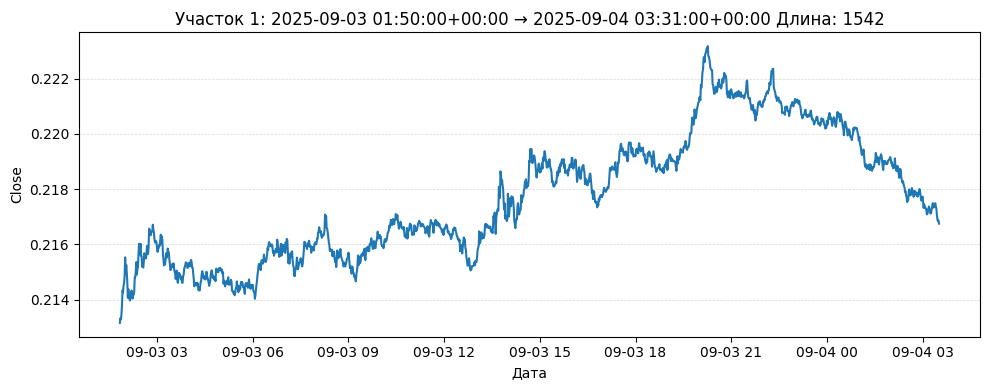

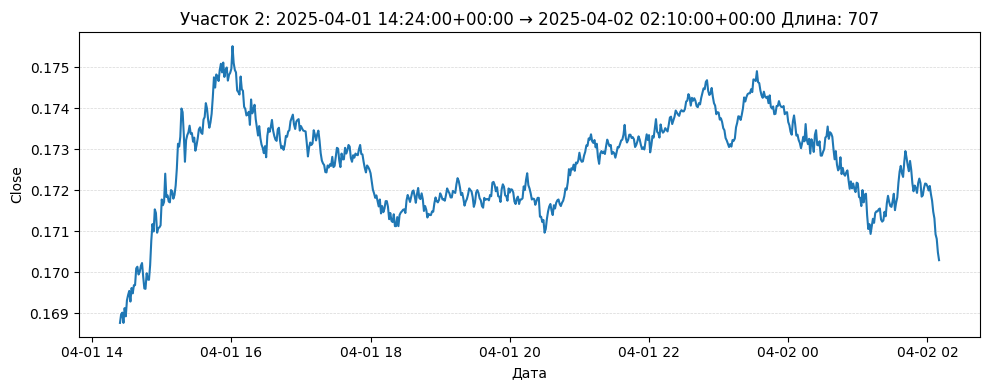

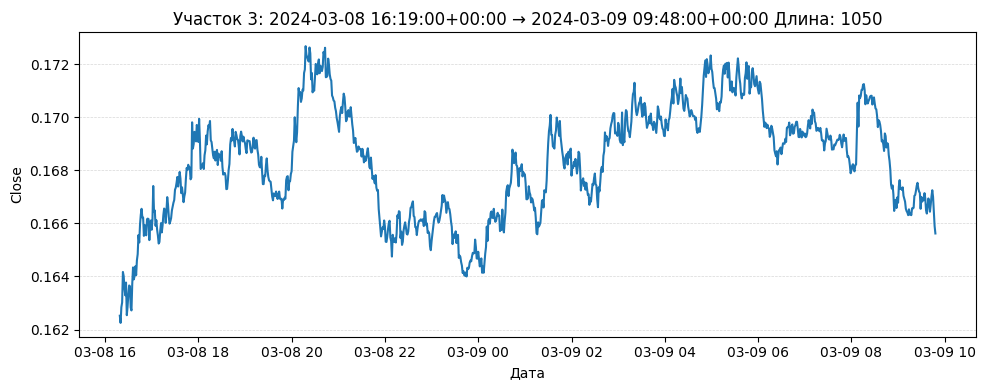

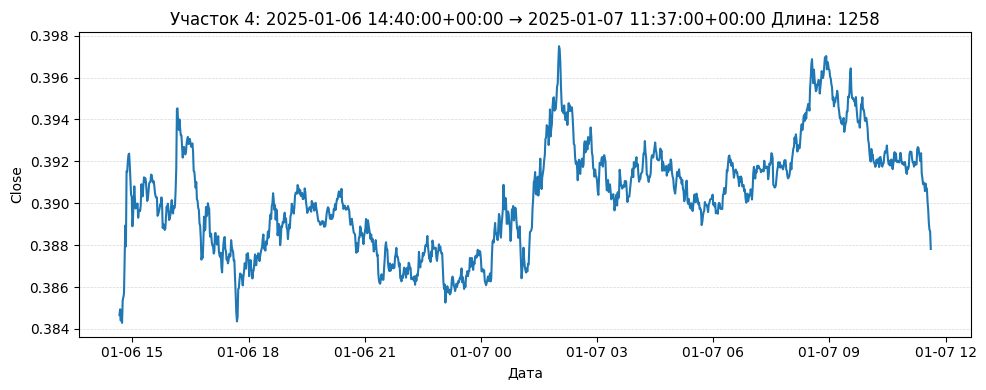

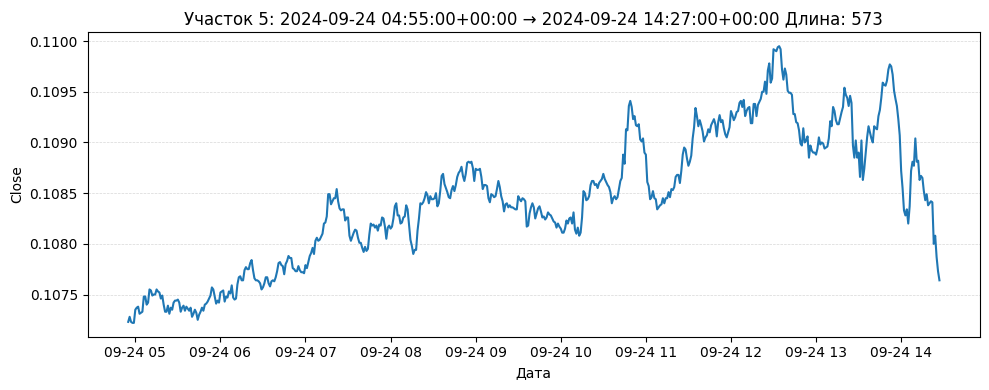

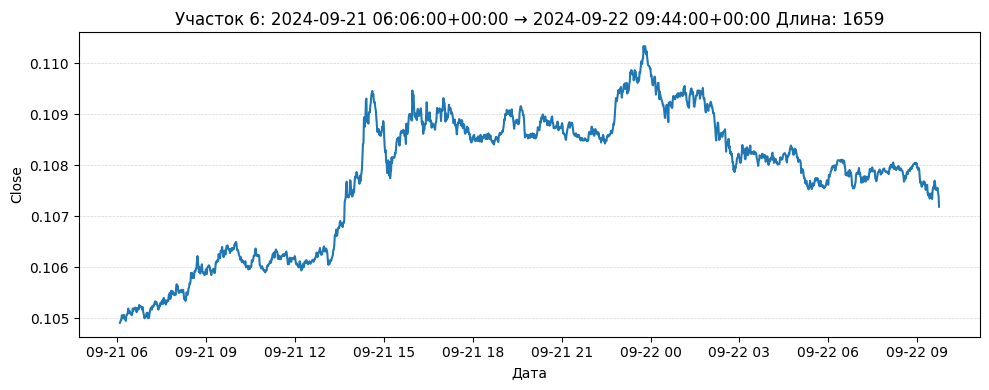

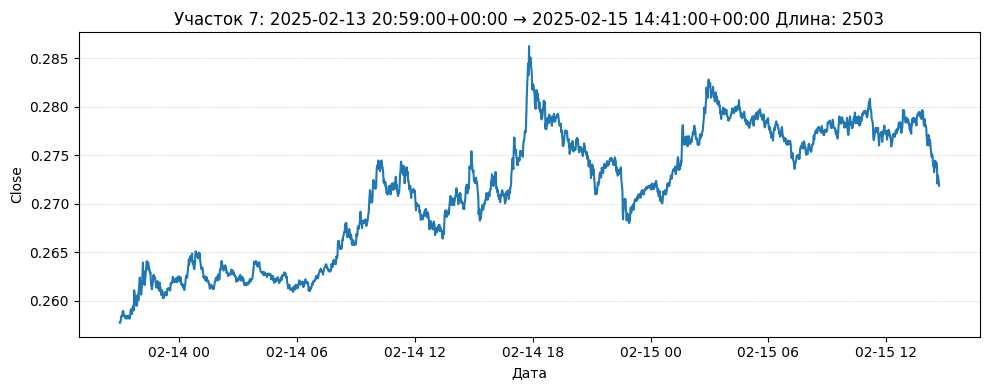

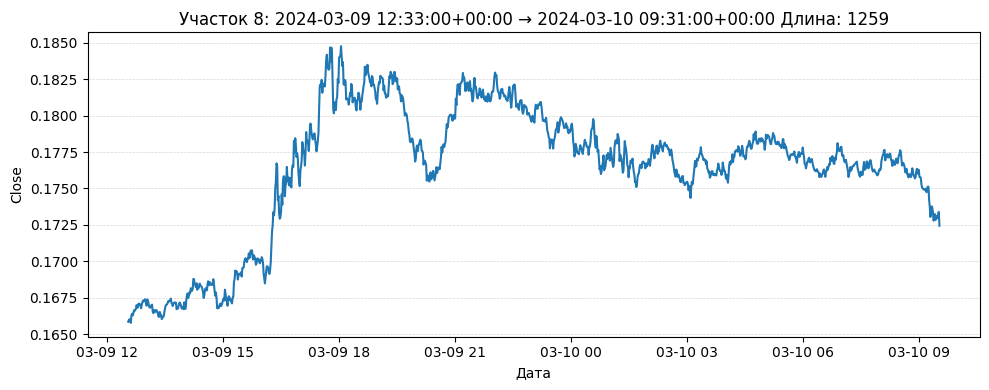

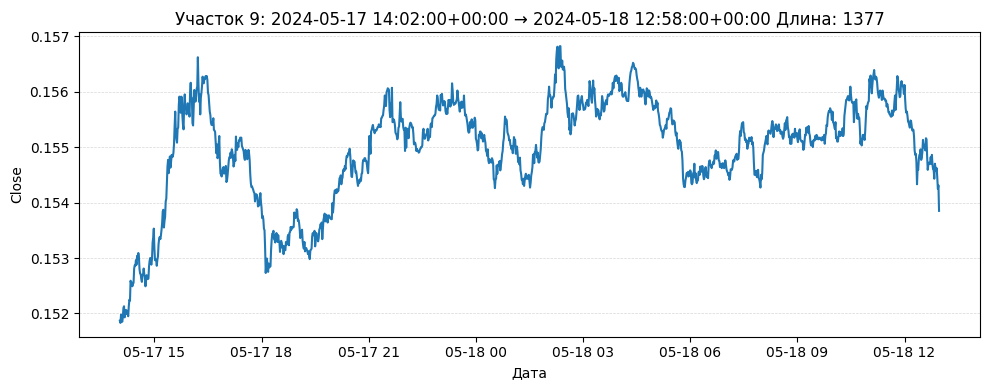

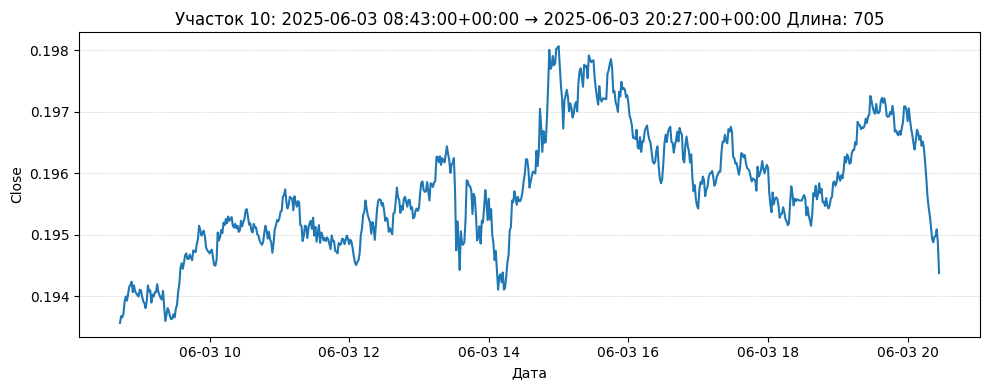

In [ ]:
# @title Фильтрация датасета на трендовые участки
df['EMA_2500'] = ema_numba(close, 2500)

buy_sig  = (df['Close'] > df['EMA_2500'])
sell_sig = (df['Close'] < df['EMA_2500'])

df['Trend_filter'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)

# 1) Получаем список участков
segments = get_intervals(df, 'Trend_filter', threshold=500)  # список DatetimeIndex

# 2) Рисуем 5 случайных участков
plot_price_with_valid(df, 'Close', segments, n_plots=10, seed=42, assume_df_tz='UTC')

In [ ]:
# @title Нормализация и нарезка данных
enriched = df.copy()
builder = DatasetBuilderForYourColumns(
    seq_len=SEQ_LEN, norm="minmax",
    labels_from="q", # change to "q" if use q-labels
    tau=1, r_mode="oracle",
    splits=SPLITS,
    batch_size=BATCH_SIZE,
    sw_mode="ClassBalance",
    feature_cols = FEATURES,
    account_cols = ACCOUNT_F,
    betta = 0.5 # процент сэмплов подлежащих удалению
)
splits = builder.fit_transform(enriched, return_indices=True, train_valid_indices=segments)
train_ds, val_ds, test_ds = builder.as_tf_datasets(splits)
test_idx = splits["test"][-1]

print("Train:", len(train_ds))
print("Val:", len(val_ds))
print("Test:", len(test_ds))

Train: 231
Val: 169
Test: 338


In [ ]:
# @title Оптимизация гиперпараметров (только для подбора)

xb, _ = next(iter(train_ds.take(1)))
feature_dim = xb.shape[-1]
best_params = optimize_hyperparameters(
    train_ds,
    val_ds,
    seq_len=SEQ_LEN,
    feature_dim=feature_dim,
    n_trials=10,
    epochs=5,
)

UNITS_PER_LAYER = best_params['units_per_layer']
DROPOUT = best_params['dropout']
LR = best_params['lr']

Epoch 01 | train: loss 0.6280, acc 0.7389, ER 0.381216 | val: loss 0.5870, acc 0.8630, macroF1 0.4600, ER 0.203276, ICp 0.9003, ICs 0.7719
Epoch 02 | train: loss 0.6153, acc 0.7439, ER 0.384578 | val: loss 0.5797, acc 0.8630, macroF1 0.4600, ER 0.237461, ICp 0.9082, ICs 0.7737
Epoch 03 | train: loss 0.6143, acc 0.7439, ER 0.391099 | val: loss 0.5756, acc 0.8630, macroF1 0.4600, ER 0.258085, ICp 0.9143, ICs 0.7753
Epoch 04 | train: loss 0.6128, acc 0.7439, ER 0.390873 | val: loss 0.5712, acc 0.8630, macroF1 0.4600, ER 0.277064, ICp 0.9219, ICs 0.7761
Epoch 05 | train: loss 0.6098, acc 0.7440, ER 0.399953 | val: loss 0.5702, acc 0.8630, macroF1 0.4600, ER 0.280291, ICp 0.9215, ICs 0.7751
Epoch 06 | train: loss 0.6072, acc 0.7440, ER 0.410831 | val: loss 0.5657, acc 0.8630, macroF1 0.4600, ER 0.305973, ICp 0.9274, ICs 0.7768
Epoch 07 | train: loss 0.5992, acc 0.7452, ER 0.430048 | val: loss 0.5580, acc 0.8629, macroF1 0.4639, ER 0.329756, ICp 0.9287, ICs 0.7785
Epoch 08 | train: loss 0.59

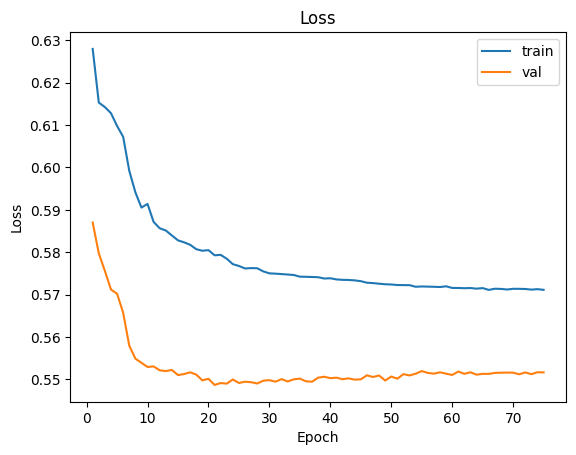

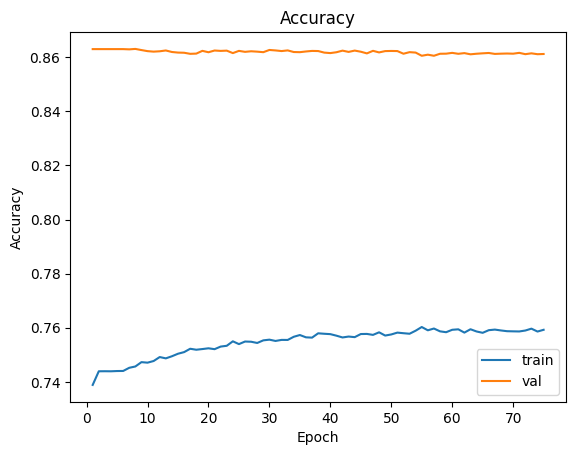

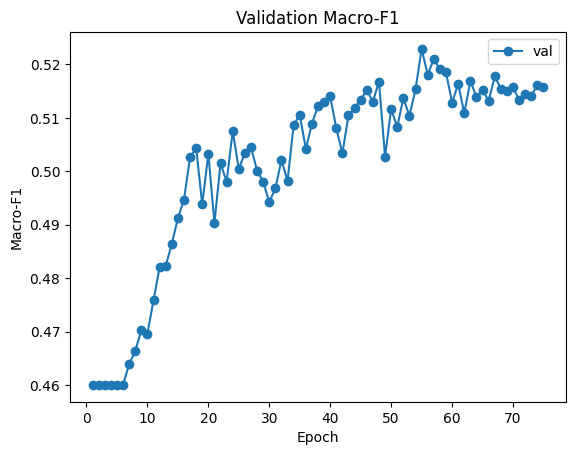

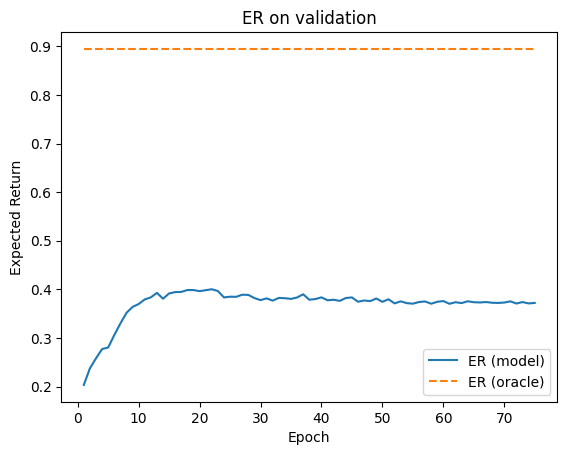

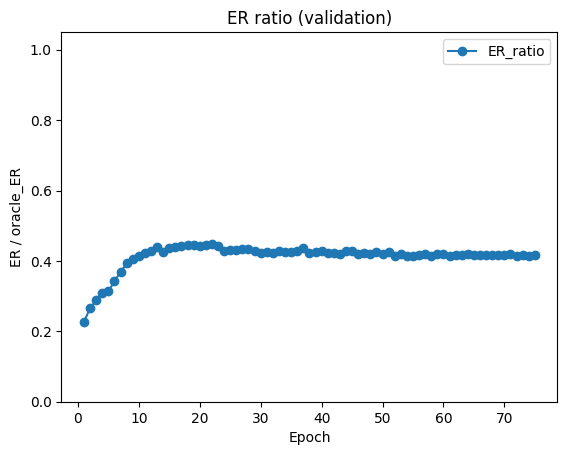

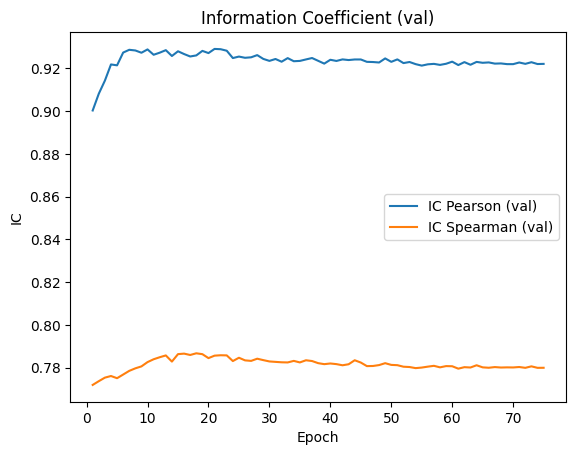

In [ ]:
# @title Обучение модели
xb, _ = next(iter(train_ds.take(1)))
backbone = build_backbone(
    seq_len=xb.shape[1],
    feature_dim=xb.shape[-1],
    units=UNITS,
    dropout=DROPOUT,
)
model = build_head(
    backbone,
    num_classes=NUM_ACTIONS,
    units=UNITS,
)

history = fit_model(
    model,
    train_ds,
    val_ds,
    epochs=EPOCHS,
    steps_per_epoch=None,
    lr=LR,
    grad_clip_norm=GRAD_CLIP_NORM,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    lr_mode=LR_MODE,
    onecycle_max_lr=ONECYCLE_MAX_LR,
    onecycle_pct_start=ONECYCLE_PCT_START,
    lr_restart_patience=LR_RESTART_PATIENCE,
    lr_restart_shrink=LR_RESTART_SHRINK,
    best_weights_path=BEST_WEIGHTS_PATH,
    save_backbone=SAVE_BACKBONE,
)

plot_history_curves(history)

In [ ]:
# 3) оценка на тесте
test_metrics = evaluate_dataset(model, test_ds)
print("TEST METRICS:")
for k,v in  materialize_metrics(test_metrics).items():
  print(f"{k}:{v}")

TEST METRICS:
loss:0.5581138134002686
acc:0.8531662225723267
macro_f1:0.5312004089355469
f1_per_class:[0.15157343447208405, 0.14684949815273285, 0.9095902442932129, 0.9167885184288025]
exp_return:0.3152744770050049
oracle_ER:0.8360689282417297
ER_ratio:0.37709149718284607
IC_pearson:0.91851806640625
IC_spearman:0.7644102573394775


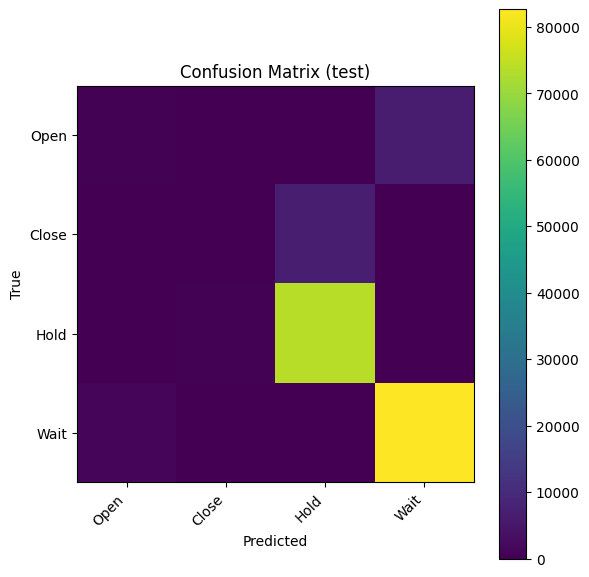

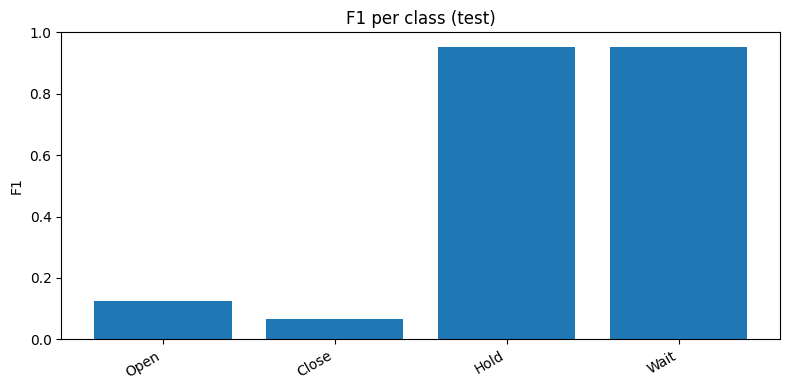

In [ ]:
# 4) конфьюжн-матрица и F1 per class на тесте
cm_test, f1_test = confusion_and_f1_on_dataset(model, test_ds)

In [ ]:
# @title Loading model
backbone = build_backbone(
    seq_len=xb.shape[1],
    feature_dim=xb.shape[-1],
    units=UNITS,
    dropout=DROPOUT,
)
model = build_head(
    backbone,
    num_classes=NUM_ACTIONS,
    units=UNITS,
)
model.load_weights("/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/q_labels_exp1/best_full_model_ep:56_f1:52.3.weights.h5")

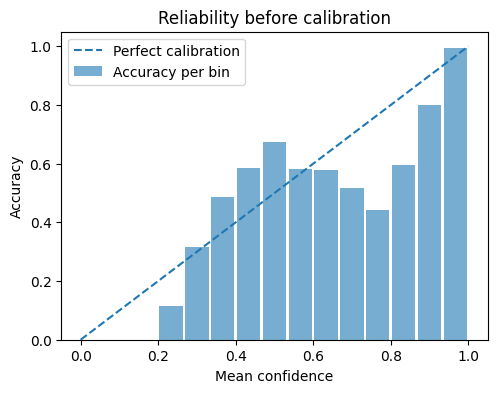

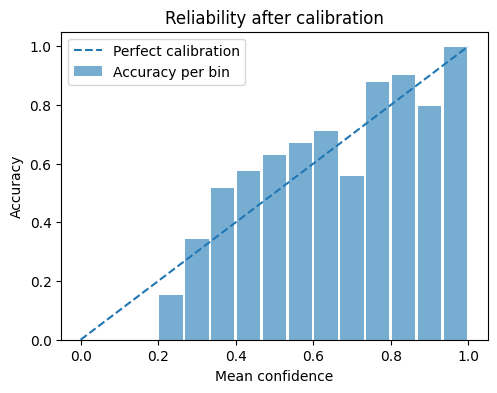

NLL before: 1.211454 | ECE before: 0.114096
NLL after:  1.188035 | ECE after:  0.118728
Temperature T: [0.9436124 2.1969504 0.5012678 1.8330445]
Saved: artifacts/calibration/temperature.json
Температуры:  [0.9436123967170715, 2.1969504356384277, 0.5012677907943726, 1.8330445289611816]


In [ ]:
# @title Калибровка модели
calib_info = calibrate_model(model, val_ds, per_class=True, init_T=1.0, plot=True)
T = calib_info['T']
print("Температуры: ", T)

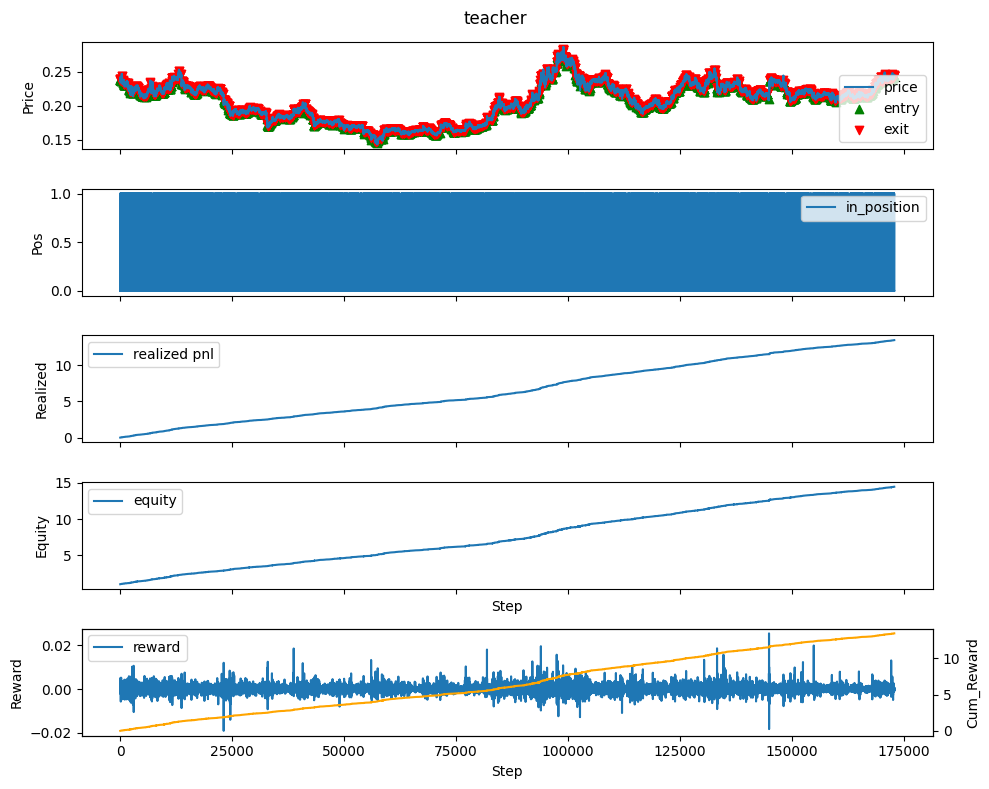

Метрики учителя:
{'Realized PnL': 13.465, 'Equity': 13.465, 'Annual Return': 40.9576, 'Sharpe Ratio': 66.8103, 'Sortino Ratio': 70.3538, 'Closed trades': 3729, 'Avg PnL per trade': 0.0037, 'Maximum Drawdown': 0.0158, 'Calmar Ratio': 2584.586, 'Profit Factor': 31652.7425, 'Win Rate': 99.9195, 'Average Win/Loss Ratio': 25.4853, 'Recovery Factor': 849.6974, 'Time Under Water': 0.4068, 'Value at Risk': 0.001}


100%|██████████| 172795/172795 [04:16<00:00, 673.22it/s]


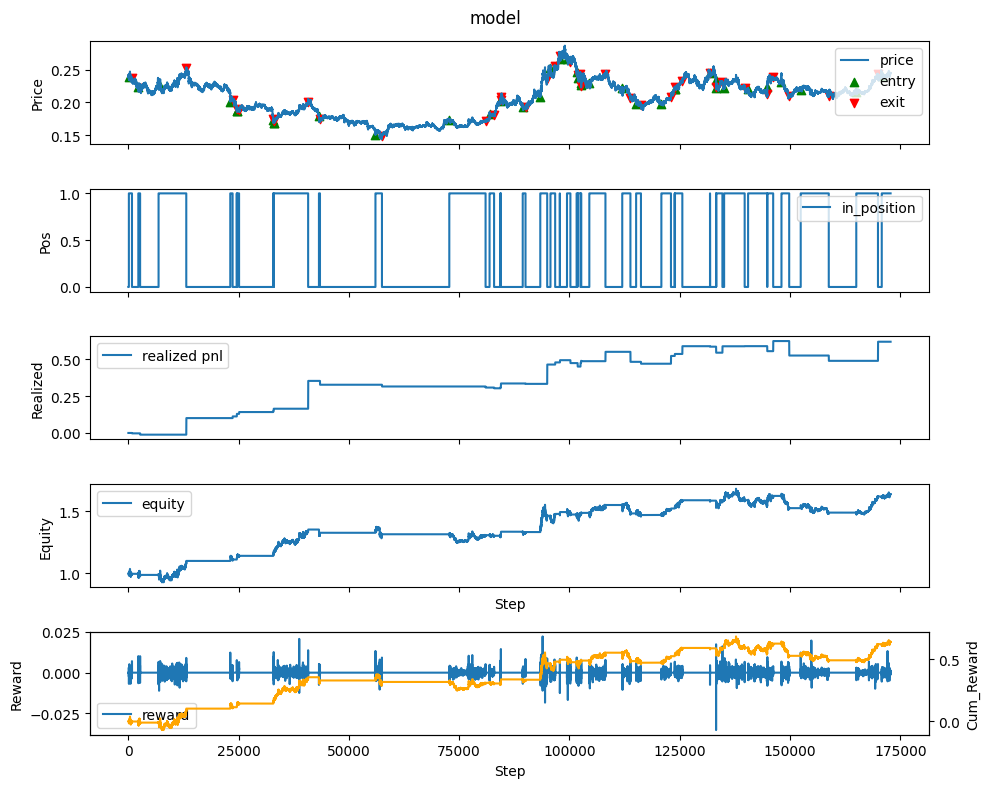


Метрики модели:
{'Realized PnL': 0.6206, 'Equity': 0.6408, 'Annual Return': 1.949, 'Sharpe Ratio': 3.4061, 'Sortino Ratio': 2.9453, 'Closed trades': 39, 'Avg PnL per trade': 0.016, 'Maximum Drawdown': 0.1239, 'Calmar Ratio': 15.7299, 'Profit Factor': 2.5482, 'Win Rate': 56.4103, 'Average Win/Loss Ratio': 1.9691, 'Recovery Factor': 5.1714, 'Time Under Water': 0.9249, 'Value at Risk': 0.0011}


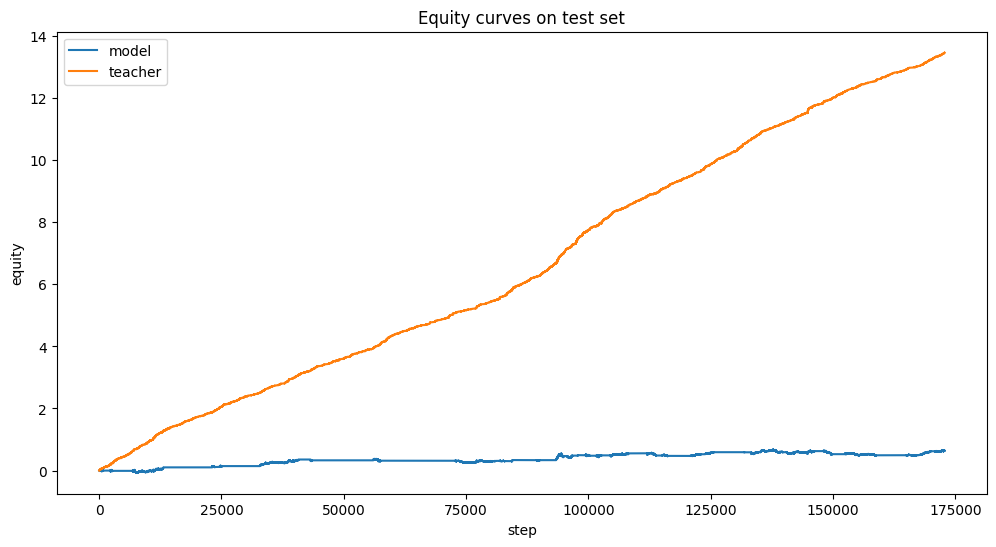

In [ ]:
# @title Запуск бэктестов: референс стратегия, модель, учитель

def run_backtest_teacher(df, environment):
    env = environment
    env.reset()
    for a_row in df[['Q_Open', 'Q_Close', 'Q_Hold', 'Q_Wait']].iloc[:-1].to_numpy():
        mask = env.action_mask()
        a_row = np.where(mask > 0.0, a_row, 1e-9)
        a_row = a_row - np.max(a_row)
        a_row_exp = np.exp(a_row) * mask
        denom = a_row_exp.sum()
        Y = np.where(denom > 0.0, a_row_exp / np.maximum(denom, 1e-8), 1.0 / 4)
        action = np.argmax(Y)
        _, _, done, _ = env.step(action)

        if done:
            break
    return env

LONG_CONFIG = EnvConfig(
    mode=1,               # работаем только от длинной позиции
    fee=0.0002,           # без комиссии
    spread=0.0001,        # без спреда
    leverage=1.0,         # без плеча
    max_steps=10**9,      # практически бесконечный эпизод
    reward_scale=1.0,     # без масштабирования вознаграждения
    valid_time = 0,       # отсрочка штрафа
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
    terminal_reward = False, # дополнительная награда по закрытию сделки
    terminal_reward_coef = 0.0, # коэффициент доп. награды
)

start, end = int(test_idx[0]), int(test_idx[-1])
df_bt = enriched.iloc[start:end+2].copy()

# env_ref = BacktestEnv(df_bt, cfg=LONG_CONFIG, price_col='Open', ppo_true=False)
# sim_ref = run_backtest(env_ref)

env_tch = BacktestEnv(df_bt, cfg=LONG_CONFIG, price_col='Open')
sim_tch = run_backtest_teacher(df_bt, env_tch)
sim_tch.plot("teacher")
print('Метрики учителя:')
print(sim_tch.metrics_report())

@tf.function
def model_infer(inputs, training=False):
    logits = model(inputs, training=False)
    return logits / T if T is not None else logits

env_model = run_backtest_with_logits(
     enriched,
     model_infer,
     feature_stats=builder.stats_features,
     seq_len=SEQ_LEN,
     start=start,
     feature_cols=builder.feature_names,
     price_col='Open',
     cfg=LONG_CONFIG,
     q_threshold = 0.65
)

env_model.plot("model")
print('\nМетрики модели:')
print(env_model.metrics_report())


# log_ref = sim_ref.logs()
log_model = env_model.logs()
log_teacher = sim_tch.logs()

plt.figure(figsize=(12,6))
# plt.plot(log_ref['equity'], label='reference')
plt.plot(log_model['equity'], label='model')
plt.plot(log_teacher['equity'], label='teacher')
plt.legend()
plt.title('Equity curves on test set')
plt.xlabel('step')
plt.ylabel('equity')
plt.show()